<font color='tomato'><font color="#CC3D3D"><p>
# DNN Modeling with ktrain

- ktrain은 tensorflow 기반의 low-code deep learning library임   
https://github.com/amaiya/ktrain  


- 아래 코드는 Seed를 설정하지 않았기 때문에 실행할 때마다 결과가 달라짐.    
여러번 실행해서 얻는 submission 화일을 앙상블해서 사용하는 것이 좋음.

### Imports

In [1]:
import ktrain
from ktrain import tabular  # tabular data에 적용
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
%matplotlib inline

### Read Data

In [3]:
# 1st round 1등팀 피처 사용
X_train = pd.read_csv(os.path.abspath('../input')+'/choi_select_547_train.csv', encoding='utf-8')
X_test = pd.read_csv(os.path.abspath('../input')+'/choi_select_547_test.csv', encoding='utf-8')
y_train = pd.read_csv(os.path.abspath('../input')+'/y_train.csv').group
IDtest = pd.read_csv(os.path.abspath('../input')+'/X_test.csv', encoding= 'cp949').custid.unique()

In [4]:
# 아래 tabular_from_df()에서는 target 필드까지 들어간 데이터프레임을 요구
train_df = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)

### Preprocessing

In [5]:
# Scaling, Imputation, train/valid 분할 등의 전처리를 수행하고 나중에 사용할 trn, val, preproc를 반환.
# validation data의 비율(현재 20%)은 val_pct로 지정
trn, val, preproc = tabular.tabular_from_df(train_df, label_columns=['group'], val_pct=0.2, random_state=42)

processing train: 17261 rows x 548 columns
['F20', 'F30', 'F40', 'F50', 'M20', 'M30', 'M40', 'M50']
   F20  F30  F40  F50  M20  M30  M40  M50
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
processing test: 4326 rows x 548 columns
['F20', 'F30', 'F40', 'F50', 'M20', 'M30', 'M40', 'M50']
    F20  F30  F40  F50  M20  M30  M40  M50
1   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
7   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
11  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
12  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
33  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0


### Modeling

In [55]:
##### MLP를 사용하여 모델링 (tabular data는 MLP만 지원). 배치 사이즈는 성능에 지대한 영향을 미침.
model = tabular.tabular_classifier('mlp', trn)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=400)

Is Multi-Label? False
done.


In [56]:
# Model Fitting: 학습율(lr)과 에포크(epochs)가 성능에 지대한 영향을 미침.
hist = learner.fit_onecycle(lr = 5e-3, epochs=3, checkpoint_folder='output')



begin training using onecycle policy with max lr of 0.005...
Epoch 1/3
44/44 [==============================] - 13s 284ms/step - loss: 1.6724 - accuracy: 0.4133 - val_loss: 1.4971 - val_accuracy: 0.4519
Epoch 2/3
44/44 [==============================] - 16s 376ms/step - loss: 1.4405 - accuracy: 0.4722 - val_loss: 1.5252 - val_accuracy: 0.4473
Epoch 3/3
44/44 [==============================] - 17s 392ms/step - loss: 1.2873 - accuracy: 0.5248 - val_loss: 1.5104 - val_accuracy: 0.4549


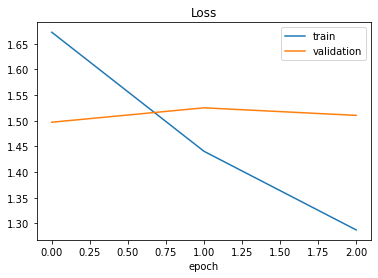

In [57]:
# Log Loss: 거의 대부분 val_loss 값이 낮을수록 LB 스코어도 낮음. 즉 val_loss의 변화가 학습에 절대적으로 중요!!!
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()

### Prediction

In [58]:
predictor = ktrain.get_predictor(learner.model, preproc)
pred = predictor.predict(X_test, return_proba=True)

['F20', 'F30', 'F40', 'F50', 'M20', 'M30', 'M40', 'M50']
   F20  F30  F40  F50  M20  M30  M40  M50
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [59]:
t = pd.Timestamp.now()
fname = f"ktrain_mlp_submission_choi_ver10.csv"
pred = pd.DataFrame(pred)
pred.columns = ['F20','F30','F40','F50','M20','M30','M40','M50']
submissions = pd.concat([pd.Series(IDtest, name="ID"), pred] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'ktrain_mlp_submission_choi_ver10.csv' is ready to submit.


<font color='tomato'><font color="#CC3D3D"><p>
# End